   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY   



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 2

NameError: name 'GridSearchCV' is not defined

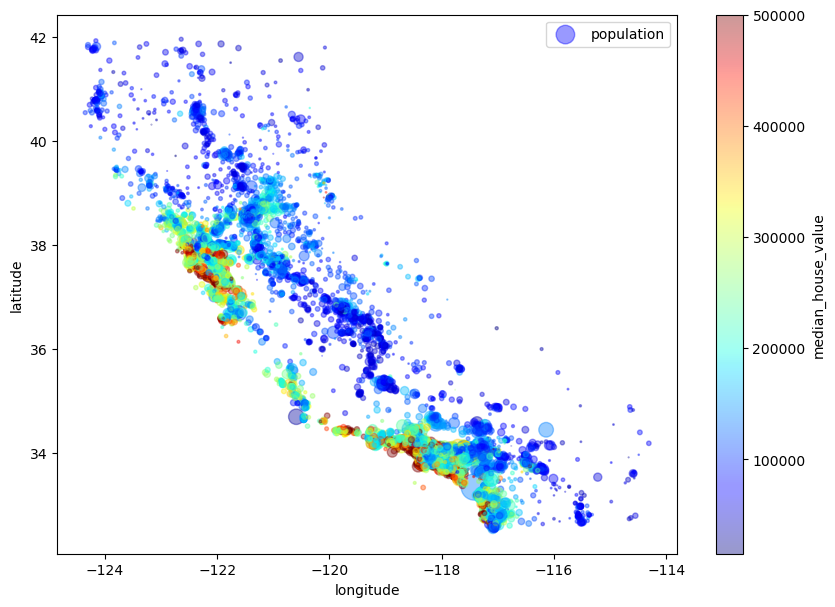

In [3]:
#CH 2 O'Reilly
import os
import tarfile
import urllib
import numpy as np

#downloading data and creating graphs
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    fetch_housing_data()
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
print(housing.head(), '\n\n\n')
print(housing.info(), '\n\n\n')
print(housing["ocean_proximity"].value_counts(), '\n\n\n')
print(housing.describe(), '\n\n\n')

#---------------------------------------------------------------------------------------------

# graphing out our data
# jupyter notebook only
# %matplotlib inline 
import matplotlib.pyplot as plt
# housing.hist(bins=50, figsize=(20, 15))
# plt.show

#-----------------------------------------------------------------------------------------------

#splitting and creating a test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print('This is the Train Set:', len(train_set), '\nAnd this is the Test Set:', len(test_set), '\n\n')

#-------------------------------------------------------------------------------------------------

#graphing income on a bell curve and stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
# housing["income_cat"].hist()

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
print("Output:\n", strat_test_set["income_cat"].value_counts() / len(strat_test_set), "\n\n", sep = "")

#removal of income_cat so data is back to original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()

#visualising the slightly more based way, shows density (lazy c:)
# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

#an even better way of visualizing with colours if you have the energy to actually do it 
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             label="population", figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"),
            colorbar=True)
plt.legend()

#------------------------------------------------------------------------------------------------

#looking for correlations idk, slap in numeric only to get rid of an annoying deprecated warning
corr_matrix = housing.corr(numeric_only=True)
print("Correlations:\n", corr_matrix["median_house_value"].sort_values(ascending=False), "\n\n", sep ='')

#plotting the numerical attributes correlated with median housing
from pandas.plotting import scatter_matrix
# attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# scatter_matrix(housing[attributes], figsize=(12,8))

#zoom into specifically into 1 plot
# housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

#--------------------------------------------------------------------------------------------

#new set, preparing data for ML
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
housing.drop("total_bedrooms", axis=1)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_
print("Values:", housing_num.median().values, "\n\n")

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

#--------------------------------------------------------------------------------

#random values idk
housing_cat = housing[["ocean_proximity"]]
print(housing_cat.head(10), "\n\n") #displays the first 10 stuff
#converting to numbers for ML to work with
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print("Values converted to Numbers:\n", housing_cat_encoded[:10], "\n\n", sep = "")
print("Values:", ordinal_encoder.categories_, "\n\n")

#categorial values to one-hot vectors
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print("Value:", housing_cat_1hot, "\n\n")
print("1 Hot Vectors:", housing_cat_1hot.toarray(), "\n\n")
print("Listed Categories:", cat_encoder.categories_, "\n\n") #same as ordinal_encoder.categories_

#-----------------------------------------------------------------------------------------------

#custom transformer that fits transforms and fit transforms
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): #no args or kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else: 
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

#-------------------------------------------------------------------------------------

#pipeline time yippe
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler())])
housing_num_tr = num_pipeline.fit_transform(housing_num)

#idk
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), 
                                  ("cat", OneHotEncoder(), cat_attribs)])
housing_prepared = full_pipeline.fit_transform(housing)

#-----------------------------------------------------------------------------------------------

#selecting and training a model 
from sklearn.linear_model import LinearRegression
# lin_reg = LinearRegression()
# lin_reg.fit(housing_prepared, housing_labels)
# some_data = housing.iloc[:5]
# some_labels = housing_labels.iloc[:5]
# some_data_prepared = full_pipeline.transform(some_data)
# print("Predictions:", lin_reg.predict(some_data_prepared), "\n\n")

from sklearn.metrics import mean_squared_error
# housing_predictions = lin_reg.predict(housing_prepared)
# lin_mse = mean_squared_error(housing_labels, housing_predictions)
# lin_rmse = np.sqrt(lin_mse)
# print("Mean Squared Error (RMSE):", lin_rmse, "\n\n")

#--------------------------------------------------------------------------------------------

#decision tree regressor
# from sklearn.tree import DecisionTreeRegressor
# tree_reg = DecisionTreeRegressor()
# tree_reg.fit(housing_prepared, housing_labels)

# #cross validation
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
#                          scoring="neg_mean_squared_error", cv=10)
# tree_rmse_scores = np.sqrt(-scores)

# def display_scores(scores):
#     print("Scores:", scores)
#     print("Mean:", scores.mean())
#     print("Standard Deviation", scores.std(), "\n\n")
    
# lin_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
#                          scoring="neg_mean_squared_error", cv=10)
# lin_rmse_scores = np.sqrt(-lin_scores)
# display_scores(lin_rmse_scores)

#-----------------------------------------------------------------------------------------

#Esemble Learning Model
# from sklearn.ensemble import RandomForestRegressor
# forest_reg = RandomForestRegressor()
# forest_reg.fit(housing_prepared, housing_labels)
# forest_predictions = forest_reg.predict(housing_prepared)
# forest_mse = mean_squared_error(housing_labels, housing_predictions)
# forest_rmse = np.sqrt(forest_mse) #something is wrong here, and I'm too lazy to fix it, so i'll just mark it
# print("Forest Value:", forest_rmse, "\n\n")
# display_scores(forest_rmse_scores)

#-----------------------------------------------------------------------------------------

# #grid search, experimentation
# from sklearn.model_selection import GridSearchCV

# param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
#                {'bootstrap': [False], 'n_estimators': [3, 10],
#               'max_features': [2, 3,4]}]
# forest_reg = RandomForestRegressor()
# grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error',
#                           return_train_score=True)

# grid_search.fit(housing_prepared, housing_labels)
# print('Grid Search:', grid_search.best_params_, "\n\n")
# print('Best Estimator:', grid_search.best_estimator_, '\n\n')
# #if grid search is initialized with refit = True, it'll retrain the whole training set, which is generally pretty poggers and based

# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)
    
#----------------------------------------------------------------------------------
    
#randomized search for large hyperparameters
#ensemble good group method idk

#-----------------------------------------------------------------------------------
from sklearn.svm import SVC
svcReg = SVC(kernel="linear", gamma=0.5, C=1.0)
svcReg.fit(housing_prepared, housing_labels)
svcPredictions = svcReg.predict(housing_prepared)
gridSearch = GridSearchCV(svcReg, param_grid, cv=5, scoring = 'neg_mean_squared_error',
                           return_train_score=True)
gridSearch.fit(housing_prepared, housing_labels)
print('Grid Search:', grid_search.best_params_, "\n\n")
print('Best Estimator:', grid_search.best_estimator_, '\n\n')
#RMSE
housingPredictions = svcReg.predict(housing_prepared)
svcMse= mean_squared_error(housing_labels, housingPredictions)
svcRmse = np.sqrt(svcMse)
print("Mean Squared Error (RMSE):", svcRmse, "\n\n")


#transformer for question 3
# from sklearn.base import BaseEstimator, TransformerMixin

# def indices_of_top_k(arr, k):
#     return np.sort(np.argpartition(np.array(arr), -k)[-k:])

# class TopFeatureSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, feature_importances, k):
#         self.feature_importances = feature_importances
#         self.k = k
#     def fit(self, X, y=None):
#         self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
#         return self
#     def transform(self, X):
#         return X[:, self.feature_indices_]

#pipeline for 4
# prepare_select_and_predict_pipeline = Pipeline([
#     ('preparation', full_pipeline),
#     ('feature_selection', TopFeatureSelector(feature_importances, k)),
#     ('svm_reg', SVR(**rnd_search.best_params_))
# ])